In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import time
from copy import deepcopy
import matplotlib.pyplot as plt
import os

from utils import *
from PATH import *
from data import *
from train import *

from torchinfo import summary

In [2]:
DATA_PATH, TRAIN_PATH

('/home/ruohuali/Desktop/depth-estimation/DIODE_selection',
 '/home/ruohuali/Desktop/depth-estimation/DIODE_selection/scan_00199')

In [3]:
# depth_mat = np.load(os.path.join(TRAIN_PATH, "00023_00199_outdoor_000_020_depth.npy"))
# depth_mat = depth_mat.squeeze()

# drawHeatmap(depth_mat, max_display=1000)
# img = cv2.imread(os.path.join(TRAIN_PATH, "00023_00199_outdoor_000_020.png"))
# plt.figure()
# plt.imshow(img)

# vals = np.unique(depth_mat)
# print(vals.shape, np.max(vals), np.min(vals))

In [4]:
names = os.listdir(TRAIN_PATH)
names = sorted(names)

prefix = []
for name in names:
    if name.endswith(".png"):
        prefix.append(name.rstrip(".png"))
# prefix

In [5]:
# diode = DIODE(TRAIN_PATHS, original=True)
# diode.example()

In [ ]:
model_device = torch.device("cpu")   
data_device = device = torch.device("cpu")       

transform = transforms.Compose([transforms.Resize( (640, 640) ),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
target_transform = transforms.Compose([transforms.Resize( (640, 640) )])

dataset = DIODE(TRAIN_PATHS, transform=transform, target_transform=target_transform, device=data_device, original=False)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

unet = RegUNet(3, 32).to(model_device)

model = train(unet, dataloader, True, device=model_device)
testViz(model, transform)

In [7]:
# unet = RegUNet(3, 32).to(model_device)
# summary(unet, input_size=(16, 3, 320, 320), device="cpu")

In [8]:
# from torchvision import models
# vgg = models.vgg16().to(device)
# summary(vgg, input_size=(16, 3, 320, 320), device="cpu")

In [9]:
# from torchvision import models
# dl = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large().to(device)
# summary(dl, input_size=(16, 3, 320, 320), device="cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 640, 640])
torch.Size([1, 3, 640, 640])
torch.Size([1, 21, 640, 640])
torch.Size([640, 640])


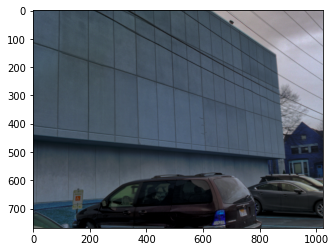

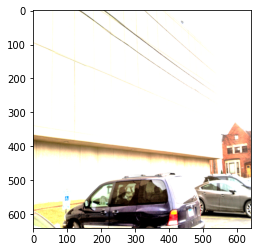

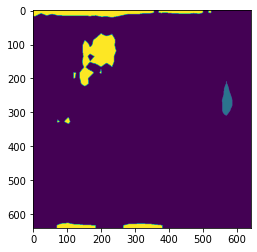

In [10]:

plt.figure()
plt.imshow(data['original_rgb'])
rgb = data['rgb'].cpu()
rgb = rgb.unsqueeze(0)
print(rgb.shape)
plt.figure()
plt.imshow(rgb.squeeze(0).permute(1, 2, 0).to(torch.int64))
print(rgb.shape)
y = dl(rgb)
y = y['out']
print(y.shape)
y = y.squeeze()
y = torch.argmin(y, 0)
print(y.shape)
plt.figure()
plt.imshow(y.detach().numpy())


38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


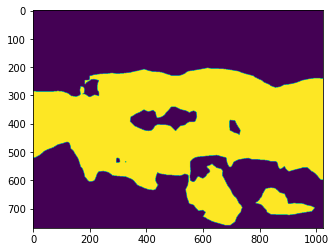

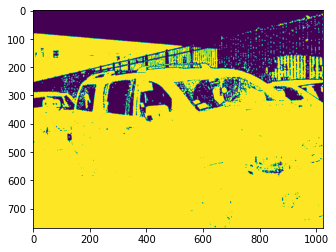

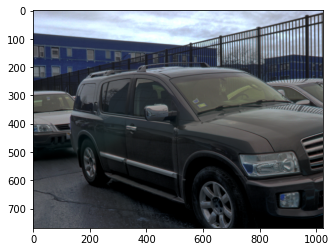

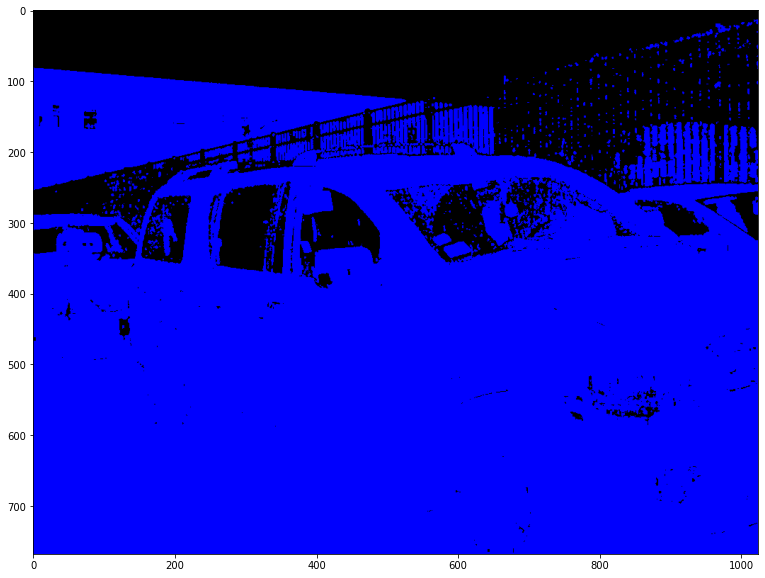

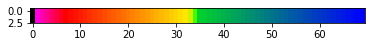

In [28]:
dl = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True).cpu()
dl.eval()
print(len(dataset))

data = dataset[12]

from PIL import Image
from torchvision import transforms
input_image = Image.open(data['rgb_path'])
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    dl.to('cuda')

with torch.no_grad():
    output = dl(input_batch)['out'][0]
output_predictions = output.argmax(0)
plt.figure()
plt.imshow(output_predictions.cpu().numpy())
plt.figure()
plt.imshow(data['original_label'])
plt.figure()
plt.imshow(data['original_rgb'])
drawHeatmap(data['original_label'])